# 続・detectron2 for まちカドまぞく ～カスタム編 その２～

<img src="https://user-images.githubusercontent.com/33882378/79055210-2ff0e600-7c86-11ea-93c6-8a65112f80f0.jpg">

標準以外の水増しを行う方法

---

In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
# VoTT のエクスポートファイルや、画像が格納されているディレクトリ
BASE_DIRECTORY = './vott-json-export/'
# VoTT のエクスポートファイル名
EXPORT_FILENAME = 'Machikado-export.json'
# 訓練データに使用する割合
TRAIN_RATIO = 0.8
# 乱数シード
RANDOM_STATE = 0

### DatasetCatalogを用意する

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from Machikado_vott import get_cat_names, get_machikado_dicts

# vott エクスポートファイルの読み込み
CAT_NAME2ID, CAT_ID2NAME = get_cat_names(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME))
dataset_dicts = get_machikado_dicts(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME), BASE_DIRECTORY, CAT_NAME2ID)

警告: name: 59.jpg - 画像サイズの不整合 image_size:(268, 201), ./vott-json-export/Machikado-export.json: (600, 600)


---

## カスタムトランスフォーム

> * detectron2/data/transforms/transform.py を参考にして書いた

In [4]:
import shapely.geometry as geometry
from fvcore.transforms.transform import Transform

class ShearTransform(Transform):
    def __init__(self, h: int, w: int, angle_h: float, angle_v: float):
        super().__init__()
        self._set_attributes(locals())
        
        self.mat = np.array([[1, np.tan(np.deg2rad(angle_h)), 0],
                             [np.tan(np.deg2rad(angle_v)), 1, 0]])
        
    def apply_image(self, img: np.ndarray) -> np.ndarray:
        assert len(img.shape) == 3, '3ch のカラー画像のみを対象とする'
        
        h, w = img.shape[:2]
        assert (self.h == h and self.w == w), '画像サイズ不整合 h:w {}:{} -> {}:{}'.format(self.h, self.w, h, w)
        
        return cv2.warpAffine(img, self.mat, (w, h))

    def apply_coords(self, coords: np.ndarray) -> np.ndarray:
        p = np.vstack([coords.T, np.ones((1, len(coords)))])
        p = np.dot(self.mat, p)
        
        return p.T

    def apply_polygons(self, polygons: list) -> list:
        # まず回転
        polygons = [self.apply_coords(p) for p in polygons]

        # 画像範囲でクリッピング
        crop_box = geometry.box(0, 0, self.w, self.h).buffer(0)
        
        cropped_polygons = []
        
        for polygon in polygons:
            polygon = geometry.Polygon(polygon).buffer(0)
            assert polygon.is_valid, '不正なポリゴン {}'.format(polygon)
            
            cropped = polygon.intersection(crop_box)
            
            if cropped.is_empty:
                continue
            
            # 複数のポリゴンに分割される可能性があるのでその処理が必要
            if not isinstance(cropped, geometry.collection.BaseMultipartGeometry):  # 単一であればリストに
                cropped = [cropped]
            
            for poly in cropped:
                if not isinstance(poly, geometry.Polygon) or not poly.is_valid:  # 不正なポリンゴンを無視する
                    continue
                
                coords = np.asarray(poly.exterior.coords)
                cropped_polygons.append(coords[:-1])  # ポリゴンの終端が先端になっているので終端を削除
        
        assert len(cropped_polygons) > 0, 'せん断変形の結果、有効な領域が残らなかった'
        
        return cropped_polygons

### ジェネレータも用意しておくと標準との統一感が出る

> * detectron2/data/transforms/transform_gen.py を参考にして書いた

In [5]:
from detectron2.data import transforms as T

class RandomShear(T.TransformGen):
    def __init__(self, angle_h_range, angle_v_range):
        super().__init__()
        self._init(locals())

    def get_transform(self, img):
        h, w = img.shape[:2]
        
        if self.angle_h_range is None:
            angle_h = 0
        else:
            angle_h = np.random.uniform(self.angle_h_range[0], self.angle_h_range[1])
            
        if self.angle_v_range is None:
            angle_v = 0
        else:
            angle_v = np.random.uniform(self.angle_v_range[0], self.angle_v_range[1])
       
        return ShearTransform(h, w, angle_h, angle_v)

---
## 学習

### カスタムデータマッパー

> * detectron2/data/dataset_mapper.py を参考にして書いた
> 
> * 以下のエラーが出る場合は、shapely をインストール
> ```
> ModuleNotFoundError: No module named 'shapely'
> ```
> ```
> pip install shapely
> ```

In [6]:
import copy
import logging
import torch

from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils

class MachikadoDatasetMapper:
    def __init__(self, cfg, custom_cfg, is_train=True):
        assert cfg.MODEL.MASK_ON, '今回はセグメンテーションのみを対象にする'
        assert not cfg.MODEL.KEYPOINT_ON, 'キーポイントは扱わない'
        assert not cfg.MODEL.LOAD_PROPOSALS, 'pre-computed proposals っていうのがよくわからん・・・・とりあえず無効前提で'
        
        self.cont_gen = None
        if custom_cfg.INPUT.CONTRAST.ENABLED:
            self.cont_gen = T.RandomContrast(custom_cfg.INPUT.CONTRAST.RANGE[0], custom_cfg.INPUT.CONTRAST.RANGE[1])
            
        self.bright_gen = None
        if custom_cfg.INPUT.BRIGHTNESS.ENABLED:
            self.bright_gen = T.RandomBrightness(custom_cfg.INPUT.BRIGHTNESS.RANGE[0], custom_cfg.INPUT.BRIGHTNESS.RANGE[1])
            
        self.extent_gen = None
        if custom_cfg.INPUT.EXTENT.ENABLED:
            self.extent_gen = T.RandomExtent(scale_range=(1, 1), shift_range=custom_cfg.INPUT.EXTENT.SHIFT_RANGE)
            
        self.crop_gen = None
        if cfg.INPUT.CROP.ENABLED:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info('CropGen used in training: ' + str(self.crop_gen))
        
        self.rotate_gen = None
        if custom_cfg.INPUT.ROTATE.ENABLE:
            self.rotate_gen = T.RandomRotation(custom_cfg.INPUT.ROTATE.ANGLE, expand=False)
        
        # ここに追加した！
        self.shear_gen = None
        if custom_cfg.INPUT.SHEAR.ENABLE:
            self.shear_gen = RandomShear(custom_cfg.INPUT.SHEAR.ANGLE_H_RANGE, custom_cfg.INPUT.SHEAR.ANGLE_V_RANGE)
            
        self.tfm_gens = utils.build_transform_gen(cfg, is_train)
        
        self.img_format = cfg.INPUT.FORMAT
        self.mask_format = cfg.INPUT.MASK_FORMAT
        
        self.custom_cfg = custom_cfg
        self.is_train = is_train

    def __call__(self, dataset_dict):
        assert 'annotations' in dataset_dict, '今回はセグメンテーションのみを対象にする'
        assert not 'sem_seg_file_name' in dataset_dict, 'パノプティックセグメンテーションは行わない'
        
        dataset_dict = copy.deepcopy(dataset_dict)
        
        image = utils.read_image(dataset_dict['file_name'], format=self.img_format)
        utils.check_image_size(dataset_dict, image)
        
        # テストの場合はアノテーションがいらないので削除して終了
        if not self.is_train:
            dataset_dict.pop('annotations', None)
            dataset_dict.pop('sem_seg_file_name', None)
            return dataset_dict
        
        # 明るさ・コントラスト
        if self.cont_gen is not None:
            tfm = self.cont_gen.get_transform(image)
            image = tfm.apply_image(image)
        if self.bright_gen is not None:
            tfm = self.bright_gen.get_transform(image)
            image = tfm.apply_image(image)
            
        # アフィン
        if self.rotate_gen is not None:
            rotate_tfm = self.rotate_gen.get_transform(image)
            image = rotate_tfm.apply_image(image)
        
        # ここに追加した！
        if self.shear_gen is not None:
            shear_tfm = self.shear_gen.get_transform(image)
            image = shear_tfm.apply_image(image)
            
        if self.extent_gen is not None:
            extent_tfm = self.extent_gen.get_transform(image)
            image = extent_tfm.apply_image(image)
        if self.crop_gen is not None:
            crop_tfm = utils.gen_crop_transform_with_instance(
                self.crop_gen.get_crop_size(image.shape[:2]), image.shape[:2], np.random.choice(dataset_dict['annotations']))
            image = crop_tfm.apply_image(image)
        
        image, transforms = T.apply_transform_gens(self.tfm_gens, image)
        
        if self.crop_gen is not None:
            transforms = crop_tfm + transforms
        if self.extent_gen is not None:
            transforms = extent_tfm + transforms
            
        # ここに追加した！
        if self.shear_gen is not None:
            transforms = shear_tfm + transforms
            
        if self.rotate_gen is not None:
            transforms = rotate_tfm + transforms

        image_shape = image.shape[:2]  # h, w
        dataset_dict['image'] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        annos = [utils.transform_instance_annotations(obj, transforms, image_shape, keypoint_hflip_indices=None)
                 for obj in dataset_dict.pop('annotations')
                 if obj.get("iscrowd", 0) == 0]

        instances = utils.annotations_to_instances(annos, image_shape, mask_format=self.mask_format)

        # マスクからバウンディングボックスを作成
        if self.crop_gen and instances.has("gt_masks"):
            instances.gt_boxes = instances.gt_masks.get_bounding_boxes()

        dataset_dict["instances"] = utils.filter_empty_instances(instances)

        return dataset_dict

### カスタマイズした設定

In [7]:
from detectron2.config import CfgNode as CN

# カスタムした設定
def get_custom_cfg():
    _C = CN()
    _C.INPUT = CN()
    _C.INPUT.ROTATE = CN()
    _C.INPUT.CONTRAST = CN()
    _C.INPUT.BRIGHTNESS = CN()
    _C.INPUT.EXTENT = CN()
    _C.INPUT.SHEAR = CN()

    _C.INPUT.ROTATE.ENABLE = True
    _C.INPUT.ROTATE.ANGLE = [-20, 20]
    _C.INPUT.CONTRAST.ENABLED = True
    _C.INPUT.CONTRAST.RANGE = (0.5, 1.5)
    _C.INPUT.BRIGHTNESS.ENABLED = True
    _C.INPUT.BRIGHTNESS.RANGE = (0.8, 1.2)
    _C.INPUT.EXTENT.ENABLED = True
    _C.INPUT.EXTENT.SHIFT_RANGE = (0.2, 0.2)
    _C.INPUT.SHEAR.ENABLE = True
    _C.INPUT.SHEAR.ANGLE_H_RANGE = (-10, 10)
    _C.INPUT.SHEAR.ANGLE_V_RANGE = (-5, 5)
    
    return _C.clone()

In [8]:
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.MODEL.MASK_ON = True

cfg.INPUT.CROP.ENABLED = False
cfg.INPUT.CROP.SIZE = [0.8, 0.8]

custom_cfg = get_custom_cfg()

custom_cfg.INPUT.ROTATE.ENABLE = False
custom_cfg.INPUT.EXTENT.ENABLED = False
# custom_cfg.INPUT.SHEAR.ENABLE = False

---
### テスト表示


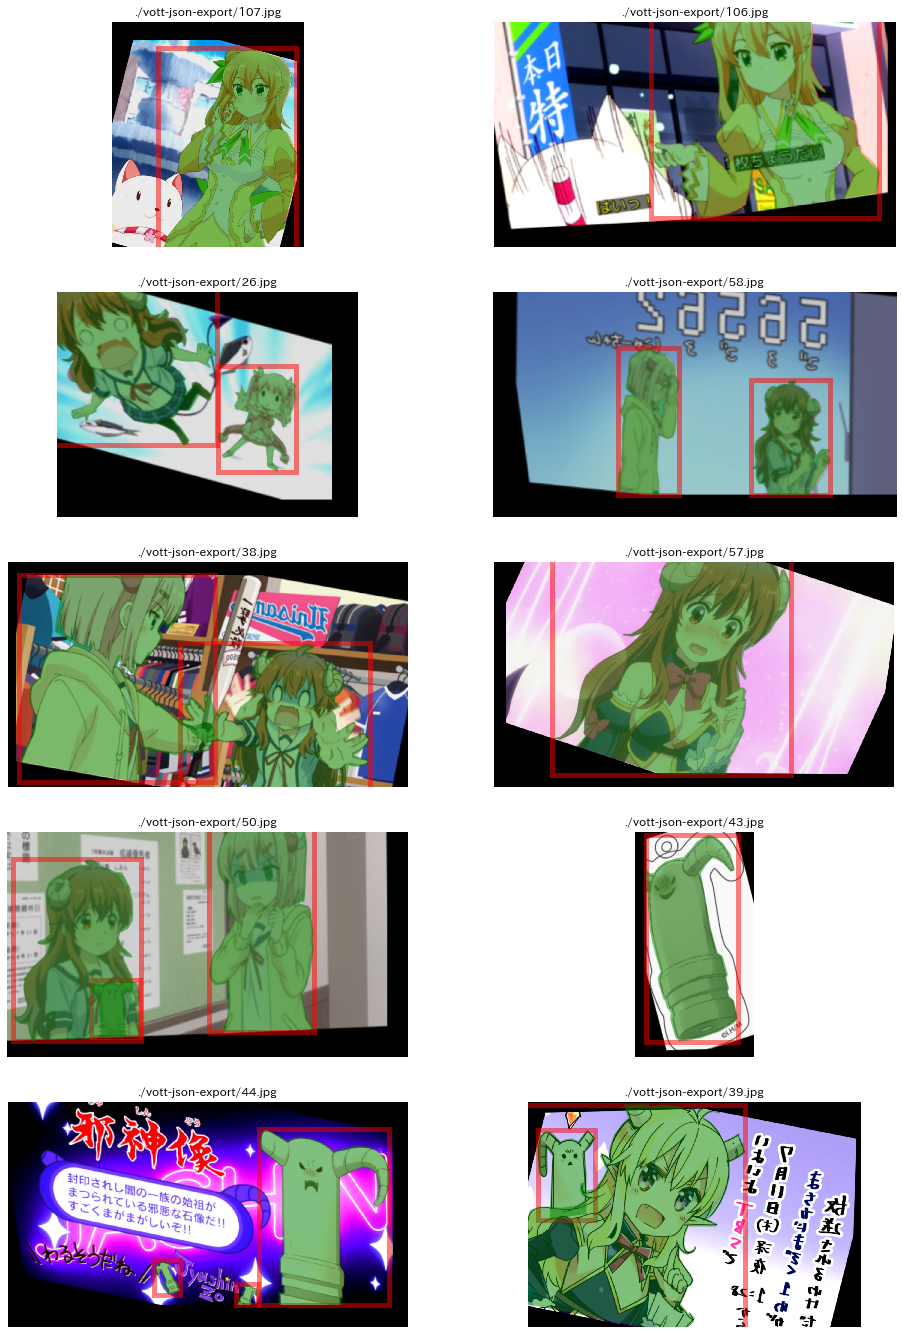

In [9]:
from plot_dataset_mapper import plot_dataset_mapper

# random.seed(RANDOM_STATE)
mapper = MachikadoDatasetMapper(cfg, custom_cfg=custom_cfg, is_train=True)
plot_dataset_mapper(dataset_dicts, mapper)